In [1]:
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image

In [4]:
#Toto je zbytečný, ale fancy na larger projekty
#V Google Collab 
data_dir = "Data/"

#Nadefinované labels dle dokumentace na Kagglu
disease_label = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Demented",
}

In [5]:
df_train = pd.read_parquet(f"{data_dir}train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow") #loadujeme parquet dataset
df_test  = pd.read_parquet(f"{data_dir}test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
df_test.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [6]:
row = df_train.iloc[0].values
#image = row.reshape(128,128)
#plt.imshow(image, cmap='gray')
#plt.show()
row

array([{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xc0\x00\x0b\x08\x00\x80\x00\x80\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x05\x06\x08\x04\x02\x03\x01\t\xff\xc4\x008\x10\x00\x01\x03\x03\x03\x02\x05\x03\x01\x05\x08\x03\x00\x00\x00\x00\x01\x02\x03\x04\x00\x05\x11\x06\x07\x12!1\x13"AQa\x142q\x81\x08\x15R\x91\xa1#$3Bb\x92\xb1\xd1\x16r\x82\xff\xda\x00\x08\x01\x01\x00\x00?\x00\xfeUQE\x14QE\x14QE\x14QE\x14QE\x14W\xea\x1bS\x8bJ\x12\x92\xa5(\xe0$\x0c\x92\x7f\x157\x07BjK\x9a\x1c\\;\x05\xceRZ\xfb\xd4\xd4G\x14\x13\xf9\xc0\xe9\xd8\xd4l\xfbL\xdbZ\xf8\xcc\x86\xfcU{<\xd9G\xcf\xadu\xda\xb4\x95\xee\xfaH\xb6\xd9\xe7O\xc63\xf4\xd1\x96\xe63\xdb\xb

In [7]:
#df_test/df_train jsou ve formátu slovníku obsahující jednotlivé bytes kvůli .parquet file type
def dict_to_image(image_dict): #přijímá argument slovníku -> df_test nebo df_train
    if isinstance(image_dict, dict) and 'bytes' in image_dict: #pokud je image_dict slovník a obsahuje binar. data z .parquet file
        byte_string = image_dict['bytes'] #binar data uložím
        nparr = np.frombuffer(byte_string, np.uint8) #převede binar data na array čísel (8 bit čísla)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE) #cv dekdoduje array, nahodí grayscale a vracíme img
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")
    
df_train['img_arr'] = df_train['image'].apply(dict_to_image) #vytvoříme new sloupec
df_train.drop("image", axis=1, inplace=True)

df_test['img_arr'] = df_test['image'].apply(dict_to_image)
df_test.drop("image", axis=1, inplace=True)
df_train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [8]:
df_test.shape

(1280, 2)

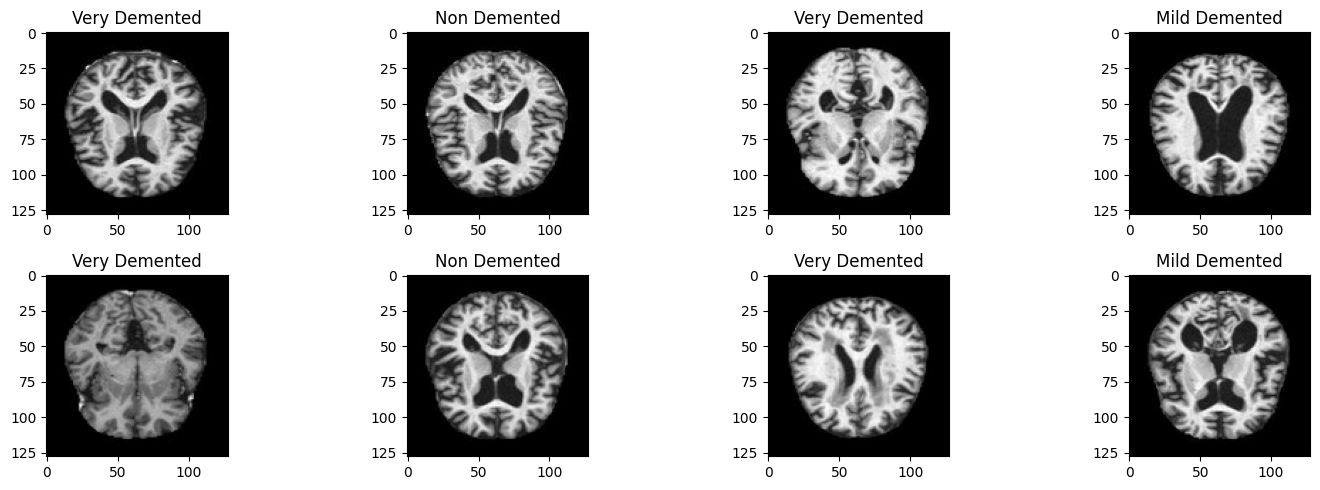

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df_test))
    axes.imshow(df_train.iloc[rand]['img_arr'], cmap="gray")
    axes.set_title(disease_label[df_train.iloc[rand]['label']])
plt.tight_layout()
plt.show()

In [10]:
N_CLASSES = df_train['label'].nunique() #tridy

#hyperparam 
learning_rate = 0.001
NEPOCHS = 10
batch_size = 32


# Use a torch dataset/dataloader to handle feeding our data in the model


class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["img_arr"] # Get the label from the df
        label = self.dataframe.iloc[idx]["label"] # Get the img numpy array from the df
        # The CNN requires we add a channel dimension i.e. (128, 128) -> (1, 128, 128)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        return image, label
    
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.out = nn.Linear(128, N_CLASSES)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x


# Create dataset and dataloader
train_dataset = ImageDataset(df_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


def train_model(model, loader, optimizer, num_epochs=NEPOCHS):
    # Initialize model, loss function, and optimizer
    criterion = nn.CrossEntropyLoss()

    # Training loop
    train_losses = []
    for epoch in tqdm.tqdm(range(num_epochs), total=num_epochs):
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0], data[1]
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        epoch_loss = running_loss / len(loader)
        train_losses.append(epoch_loss)

    print('Finished Training')
    return model, train_losses
model = BaselineCNN()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model, train_losses = train_model(model, train_loader, optimizer)

100%|██████████| 10/10 [09:30<00:00, 57.06s/it]

Finished Training


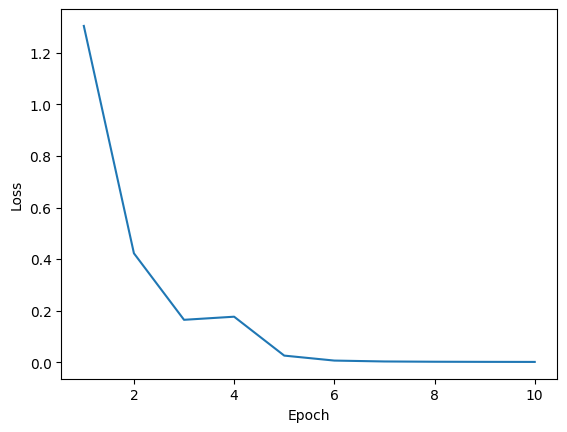

In [11]:
plt.plot(np.arange(1, 11), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [12]:
def predict(m, dl, device):
    m.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in dl:
            images = images
            outputs = m(images)
            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

def result_summary(predictions, true_labels):
    # Accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    print('Confusion Matrix:')
    print(conf_matrix)
    
predictions, true_labels = predict(model, train_loader, device)
result_summary(predictions, true_labels)

Accuracy: 1.0000
Confusion Matrix:
[[ 724    0    0    0]
 [   0   49    0    0]
 [   0    0 2566    0]
 [   0    0    0 1781]]


In [13]:
test_dataset = ImageDataset(df_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions_test, test_labels = predict(model, test_loader, device)

result_summary(predictions_test, test_labels)

Accuracy: 0.9742
Confusion Matrix:
[[160   0   5   7]
 [  0  14   0   1]
 [  1   0 628   5]
 [  0   0  14 445]]


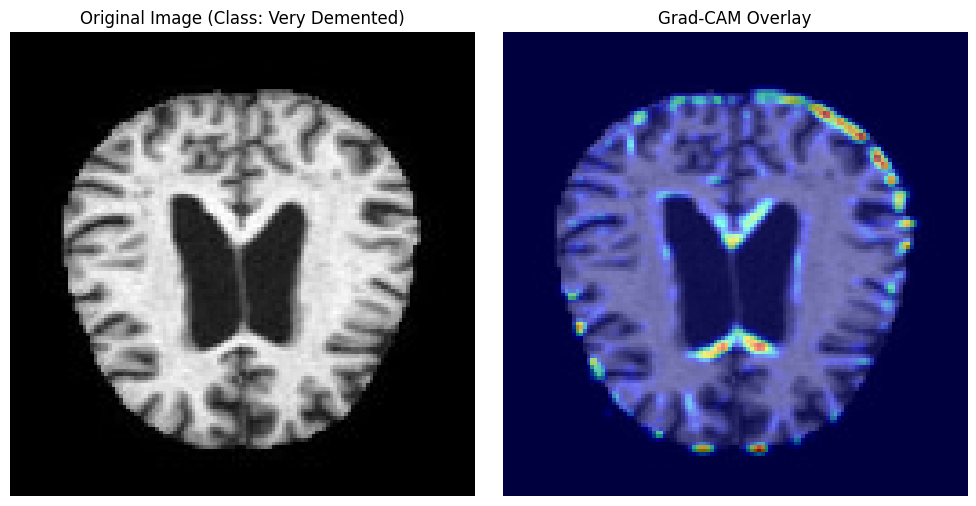

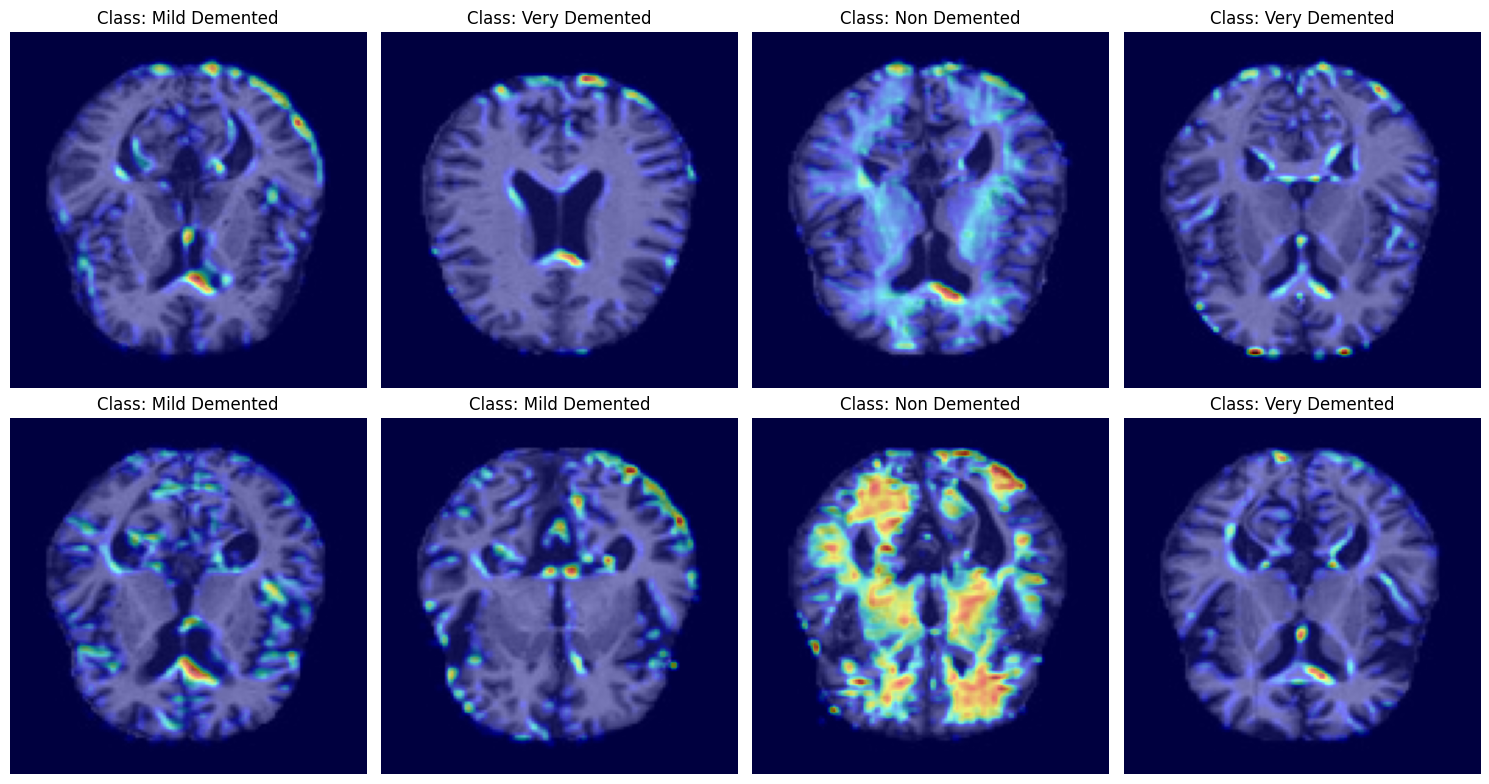

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        target = output[:, target_class]

        self.model.zero_grad()
        target.backward(retain_graph=True)

        weights = torch.mean(self.gradients, dim=(2, 3))  #global průměr
        cam = torch.zeros(self.activations.shape[2:], dtype=torch.float32)
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]

        cam = F.relu(cam)
        cam = cam / torch.max(cam)  #normalizace
        return cam.detach().cpu().numpy()

#zvýraznění tříd
class_weighting = {
    'Very Demented': 1.5,
    'Mild Demented': 1.3,
    'Moderate Demented': 1.2,
    'Non Demented': 1.0
}

def adjust_cam(cam, label):
    weight = class_weighting.get(label, 1.0)
    cam = cam ** weight  #zvýraznění dle váhy
    return cam / np.max(cam)  

#inicializace
model = model.to(device)
grad_cam = GradCAM(model, model.conv2)

#testování na random brázku
input_image, label = test_dataset[0]
input_tensor = input_image.unsqueeze(0).to(device)  
#real class
true_class = label.item()
true_label = disease_label[true_class]

#tvorba GradCAM pro realnou classu
cam_map = grad_cam.generate_cam(input_tensor, true_class)
cam_map = adjust_cam(cam_map, true_label)

#resize protože byl problem s fitem, ale tohle to nějak řeší
cam_map_resized = F.interpolate(torch.tensor(cam_map).unsqueeze(0).unsqueeze(0), size=input_image.shape[1:], mode='bilinear', align_corners=False).squeeze(0).squeeze(0).numpy()


plt.figure(figsize=(10, 5))

# Originální obrázek
plt.subplot(1, 2, 1)
plt.imshow(input_image.squeeze(0).cpu(), cmap='gray')
plt.title(f'Original Image (Class: {true_label})')
plt.axis('off')

# Grad-CAM překryv
plt.subplot(1, 2, 2)
plt.imshow(input_image.squeeze(0).cpu(), cmap='gray')
plt.imshow(cam_map_resized, cmap='jet', alpha=0.5)
plt.title('Grad-CAM Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()

# aplikování gradcamu
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axs = ax.flatten()
for i, axes in enumerate(axs):
    idx = np.random.randint(0, len(test_dataset))
    input_image, label = test_dataset[idx]
    input_tensor = input_image.unsqueeze(0).to(device)
    cam_map = grad_cam.generate_cam(input_tensor, label.item())

    label_name = disease_label[label.item()]
    cam_map = adjust_cam(cam_map, label_name)
    
    cam_map_resized = F.interpolate(torch.tensor(cam_map).unsqueeze(0).unsqueeze(0), size=input_image.shape[1:], mode='bilinear', align_corners=False).squeeze(0).squeeze(0).numpy()

    axes.imshow(input_image.squeeze(0).cpu(), cmap='gray')
    axes.imshow(cam_map_resized, cmap='jet', alpha=0.5)
    axes.set_title(f'Class: {label_name}')
    axes.axis('off')

plt.tight_layout()
plt.show()
